In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from pathlib import Path

import random
import torch


In [2]:
# ============================================================================
# REPORT-COMPLIANT PLOT CONFIGURATION
# ============================================================================
# Set consistent style for all plots
plt.style.use('seaborn-v0_8-whitegrid')

# Global matplotlib parameters for report-quality figures
plt.rcParams.update({
    # Figure size (width, height) in inches - suitable for reports
    'figure.figsize': (8, 5),
    'figure.dpi': 150,
    
    # Font sizes
    'font.size': 11,
    'axes.titlesize': 13,
    'axes.labelsize': 11,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'legend.title_fontsize': 11,
    
    # Font weight
    'axes.titleweight': 'bold',
    'axes.labelweight': 'bold',
    
    # Line widths
    'axes.linewidth': 1.2,
    'grid.linewidth': 0.8,
    'lines.linewidth': 1.5,
    
    # Grid style
    'grid.alpha': 0.3,
    'grid.linestyle': '--',
    
    # Save figure settings
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.1,
})

# Color palette for consistency
REPORT_COLORS = {
    'primary': '#2E86AB',
    'secondary': '#A23B72', 
    'tertiary': '#F18F01',
    'quaternary': '#C73E1D',
    'normal': '#2E86AB',
    'anomaly': '#F18F01'
}
# ============================================================================

## Helper functions

In [3]:
# ============================================================================
# GLOBAL CONFIGURATION: Plot Saving
# ============================================================================
SAVE_PLOTS = True
# ============================================================================

REPORT_IMAGES_DIR = '../Plots/Task1'
os.makedirs(REPORT_IMAGES_DIR, exist_ok=True)

def save_figure_for_report(filename, dpi=300, bbox_inches='tight'):
    """
    Persist the current matplotlib figure under the Task 1 plots directory.

    Args:
        filename: Target filename such as 'task1_class_distribution.png'.
        dpi: Output resolution (defaults to 300).
        bbox_inches: Matplotlib bounding box mode (defaults to 'tight').
    """
    if not SAVE_PLOTS or not filename:
        return

    filepath = os.path.join(REPORT_IMAGES_DIR, filename)
    plt.savefig(filepath, dpi=dpi, bbox_inches=bbox_inches)
    print(f"Figure saved to: {filepath}")

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"The device is set to: {device}")

The device is set to: cuda


In [5]:
# Seed al the libraries to ensure reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # for multi-GPU setups

# Example: setting a seed for reproducibility
set_seed(42)

In [6]:
df_train_val = pd.read_csv('../data/raw/train.csv')
df_test = pd.read_csv('../data/raw/test.csv')

In [7]:
df_train_val

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,binary_label
0,0,udp,private,SF,28,0,0,3,0,0,...,0.36,0.65,0.36,0.00,0.09,0.0,0.56,0.0,dos,1
1,0,icmp,eco_i,SF,8,0,0,0,0,0,...,1.00,0.00,1.00,0.50,0.00,0.0,0.00,0.0,probe,1
2,0,tcp,daytime,S0,0,0,0,0,0,0,...,0.02,0.05,0.00,0.00,1.00,1.0,0.00,0.0,dos,1
3,0,tcp,http,SF,216,3396,0,0,0,0,...,1.00,0.00,0.14,0.02,0.00,0.0,0.00,0.0,normal,0
4,0,tcp,http,SF,348,277,0,0,0,0,...,1.00,0.00,0.01,0.07,0.00,0.0,0.00,0.0,normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18826,0,tcp,http,SF,328,1231,0,0,0,0,...,1.00,0.00,0.02,0.02,0.00,0.0,0.00,0.0,normal,0
18827,0,tcp,http,SF,214,928,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,normal,0
18828,0,tcp,http,SF,253,11905,0,0,0,0,...,1.00,0.00,0.01,0.02,0.00,0.0,0.00,0.0,normal,0
18829,0,tcp,uucp_path,S0,0,0,0,0,0,0,...,0.05,0.07,0.00,0.00,1.00,1.0,0.00,0.0,dos,1


In [8]:
df_train_val["land"][0:10]

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
Name: land, dtype: int64

In [9]:
for column in df_train_val.columns:
    print(f"{column}: {df_train_val[column].unique()[0:10]}")

duration: [    0     1 12773    32     2   191    28    25     8    11]
protocol_type: ['udp' 'icmp' 'tcp']
service: ['private' 'eco_i' 'daytime' 'http' 'exec' 'smtp' 'ftp_data' 'ssh'
 'domain_u' 'other']
flag: ['SF' 'S0' 'REJ' 'RSTO' 'RSTR' 'S2' 'S1' 'SH' 'RSTOS0' 'S3']
src_bytes: [  28    8    0  216  348  845   18 1484  309  210]
dst_bytes: [   0 3396  277  328  335 7263  255  114 8513 3200]
land: [0 1]
wrong_fragment: [3 0 1]
urgent: [0]
hot: [ 0 28  2 14  4  1  6 30 19 22]
num_failed_logins: [0 2 1 4 3]
logged_in: [0 1]
num_compromised: [  0   1   6 157 520   5   2   9 217  12]
root_shell: [0 1]
su_attempted: [0 2 1]
num_root: [  0   2   1 179 572   6 247   5 121  10]
num_file_creations: [ 0  1  2 38 14 29  4 13  8 20]
num_shells: [0 1]
num_access_files: [0 1 8 4 5 3 2]
num_outbound_cmds: [0]
is_host_login: [0]
is_guest_login: [0 1]
count: [191   1 246   5   2 140  11   6 204   7]
srv_count: [91 11  5  2 12  1 14  4  7 21]
serror_rate: [0.52 0.   1.   0.09 0.33 0.05 0.07 0.5  0.04

In [10]:
df_test

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,binary_label
0,0,udp,private,SF,1,0,0,0,0,0,...,0.03,0.85,1.00,0.0,0.0,0.0,0.0,0.0,normal,0
1,0,udp,private,SF,55,51,0,0,0,0,...,1.00,0.00,0.99,0.0,0.0,0.0,0.0,0.0,normal,0
2,0,tcp,login,RSTO,0,0,0,0,0,0,...,0.07,0.06,0.00,0.0,0.0,0.0,1.0,1.0,dos,1
3,0,tcp,ftp,S0,0,0,0,0,0,0,...,0.00,0.11,0.00,0.0,1.0,1.0,0.0,0.0,dos,1
4,0,tcp,courier,REJ,0,0,0,0,0,0,...,0.07,0.05,0.00,0.0,0.0,0.0,1.0,1.0,dos,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5821,0,udp,domain_u,SF,46,85,0,0,0,0,...,1.00,0.01,0.00,0.0,0.0,0.0,0.0,0.0,normal,0
5822,0,udp,domain_u,SF,45,45,0,0,0,0,...,0.89,0.01,0.00,0.0,0.0,0.0,0.0,0.0,normal,0
5823,0,udp,domain_u,SF,44,79,0,0,0,0,...,1.00,0.00,0.01,0.0,0.0,0.0,0.0,0.0,normal,0
5824,0,udp,private,SF,54,52,0,0,0,0,...,1.00,0.00,0.84,0.0,0.0,0.0,0.0,0.0,normal,0


Figure saved to: ../Plots/Task1/task1_attack_label_distribution.png


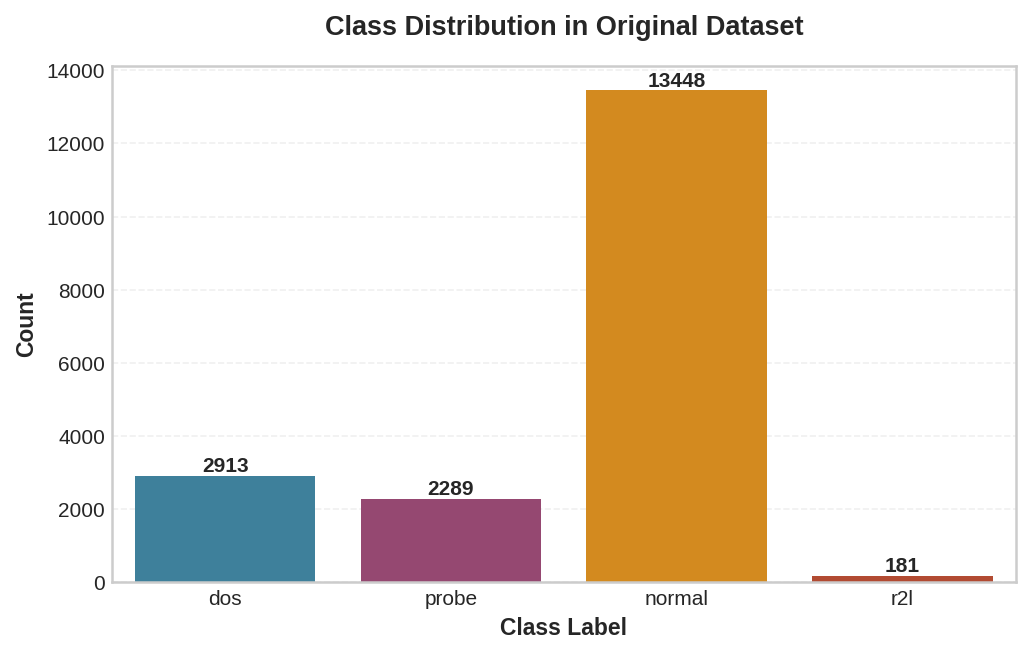

In [11]:
plt.figure(figsize=(7, 4.5))
colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']
ax = sns.countplot(data=df_train_val, x='label', hue='label', palette=colors, legend=False)

# Add count labels on top of bars
for container in ax.containers:
    ax.bar_label(container, fontsize=10, fontweight='bold')

plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title('Class Distribution in Original Dataset', pad=15)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
save_figure_for_report('task1_attack_label_distribution.png')
plt.show()

Figure saved to: ../Plots/Task1/task1_binary_label_distribution.png


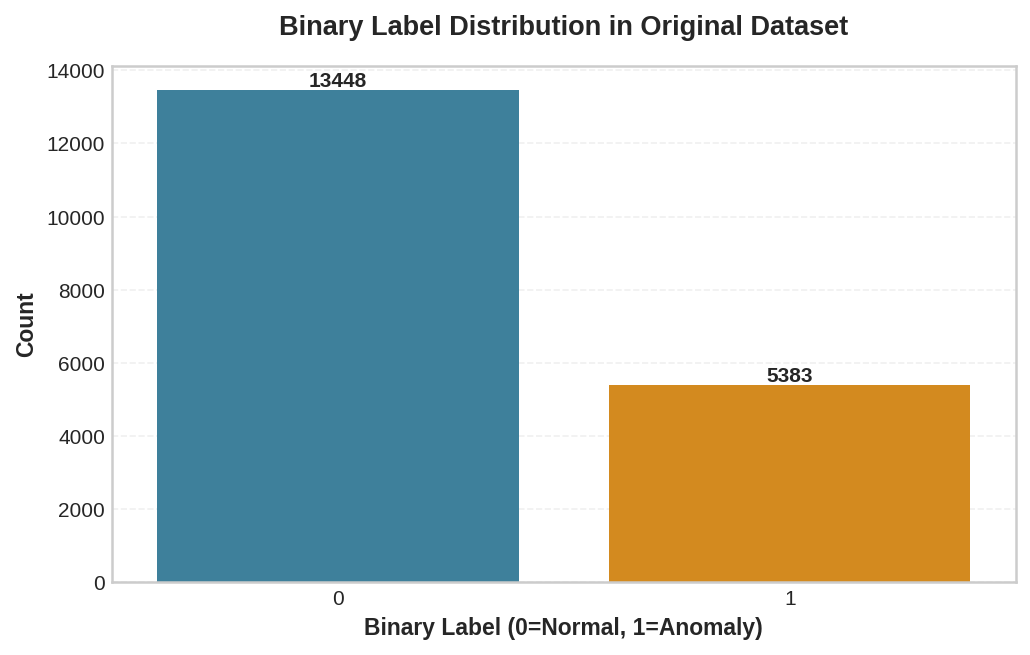

In [12]:
plt.figure(figsize=(7, 4.5))
colors = ['#2E86AB', '#F18F01']
ax = sns.countplot(data=df_train_val, x='binary_label', hue='binary_label', palette=colors, legend=False)

# Add count labels on top of bars
for container in ax.containers:
    ax.bar_label(container, fontsize=10, fontweight='bold')

plt.xlabel('Binary Label (0=Normal, 1=Anomaly)')
plt.ylabel('Count')
plt.title('Binary Label Distribution in Original Dataset', pad=15)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
save_figure_for_report('task1_binary_label_distribution.png')
plt.show()

Figure saved to: ../Plots/Task1/task1_categorical_features_distribution.png


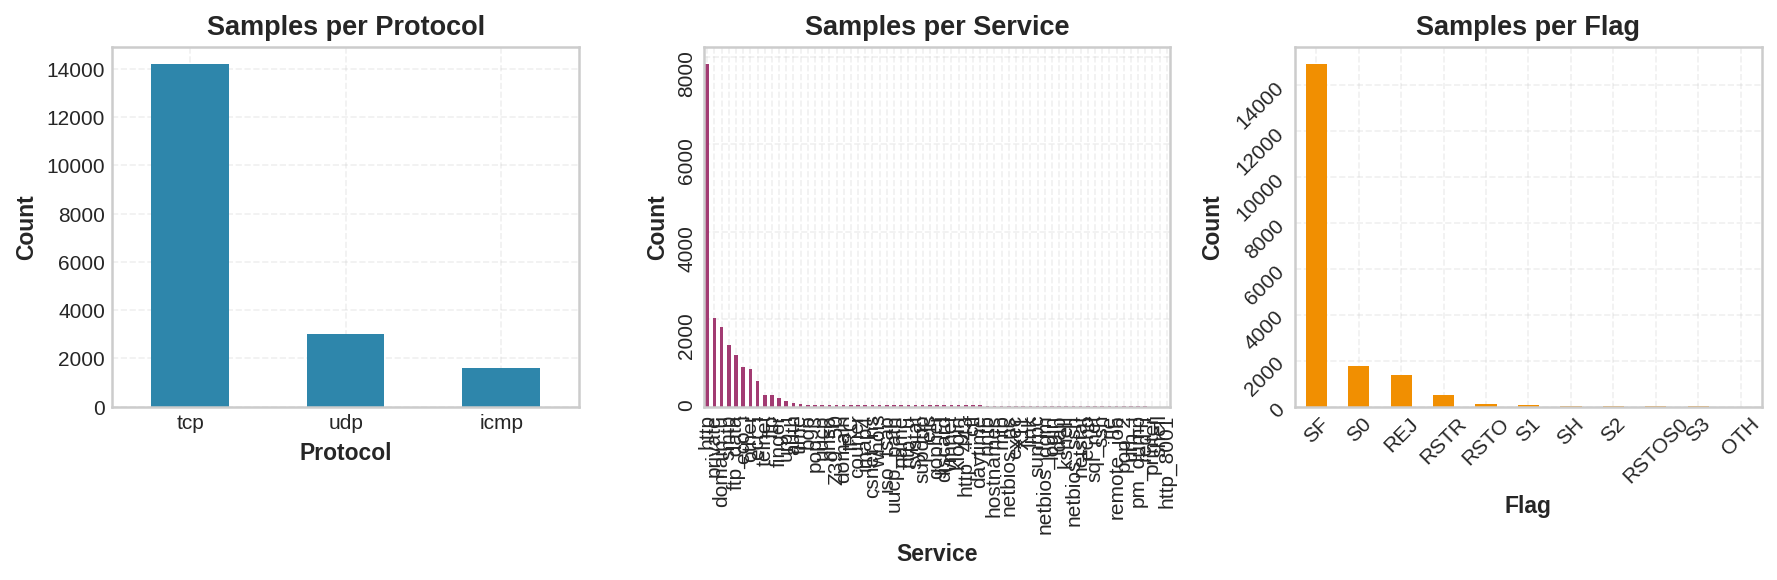

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Protocol type
df_train_val["protocol_type"].value_counts().plot(kind="bar", ax=axes[0], color='#2E86AB')
axes[0].set_title("Samples per Protocol")
axes[0].set_xlabel("Protocol")
axes[0].set_ylabel("Count")
axes[0].tick_params(rotation=0)
axes[0].grid(axis='y', alpha=0.3, linestyle='--')

# Service
df_train_val["service"].value_counts().plot(kind="bar", ax=axes[1], color='#A23B72')
axes[1].set_title("Samples per Service")
axes[1].set_xlabel("Service")
axes[1].set_ylabel("Count")
axes[1].tick_params(rotation=90)
axes[1].grid(axis='y', alpha=0.3, linestyle='--')

# Flag
df_train_val["flag"].value_counts().plot(kind="bar", ax=axes[2], color='#F18F01')
axes[2].set_title("Samples per Flag")
axes[2].set_xlabel("Flag")
axes[2].set_ylabel("Count")
axes[2].tick_params(rotation=45)
axes[2].grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
save_figure_for_report('task1_categorical_features_distribution.png')
plt.show()
plt.close()

In [14]:
data_visual = df_train_val.drop(['label','flag','protocol_type','service','binary_label'], axis=1)

/home/ren/.local/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/home/ren/.local/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/home/ren/.local/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/home/ren/.local/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/home/ren/.local/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/home/ren/.local/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr =

Figure saved to: ../Plots/Task1/task1_feature_distributions_logscale.png


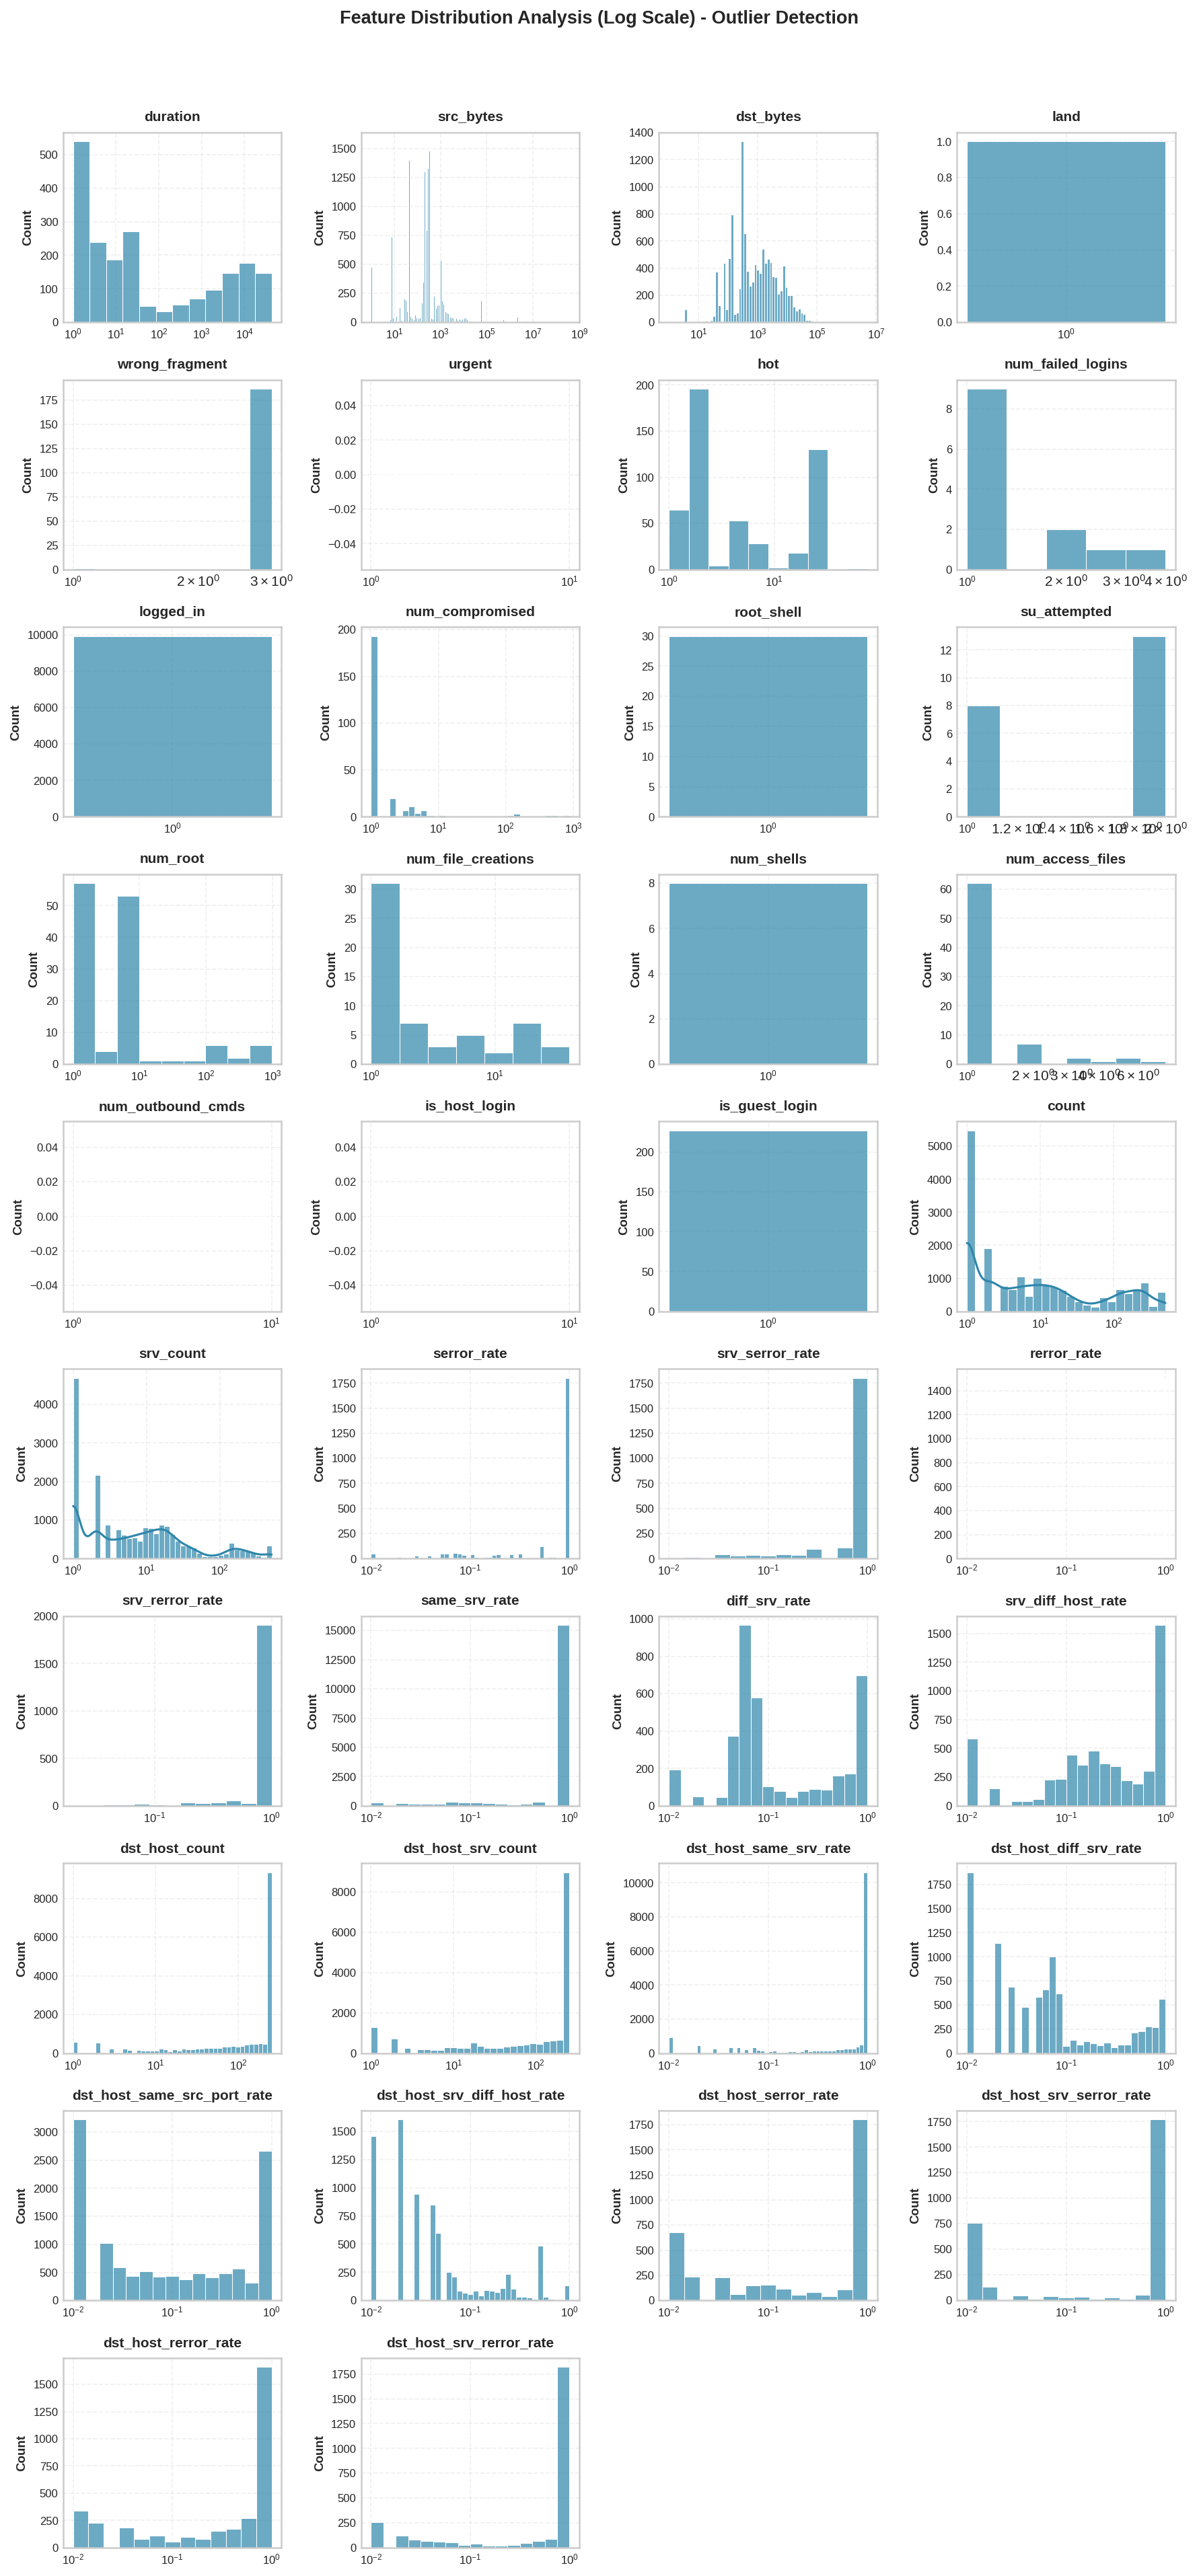


OUTLIER ANALYSIS SUMMARY
📊 All features visualized on log scale to detect outliers
🔍 Long tails indicate presence of outliers (e.g., packet/byte counts)
✓ Standardization (StandardScaler) will address these outliers


In [15]:
features = data_visual.columns

# Create a grid of subplots (4 rows x 4 columns for 16 features)
n_features = len(features)
n_cols = 4
n_rows = (n_features + n_cols - 1) // n_cols  # Ceiling division

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 2.5))
axes = axes.flatten()  # Flatten to easily iterate

for idx, feature in enumerate(features):
    ax = axes[idx]

    # Create histogram with KDE
    sns.histplot(data=data_visual, x=feature, kde=True, color='#2E86AB',
                 ax=ax, log_scale=True, alpha=0.7, edgecolor='white', linewidth=0.5)

    # Styling
    ax.set_title(feature, fontsize=10, fontweight='bold', pad=8)
    ax.set_xlabel('')
    ax.set_ylabel('Count', fontsize=9)
    ax.tick_params(labelsize=8)
    ax.grid(axis='y', alpha=0.3, linestyle='--')

# Hide any unused subplots
for idx in range(n_features, len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Feature Distribution Analysis (Log Scale) - Outlier Detection',
             fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
save_figure_for_report('task1_feature_distributions_logscale.png')
plt.show()

print("\n" + "="*70)
print("OUTLIER ANALYSIS SUMMARY")
print("="*70)
print("📊 All features visualized on log scale to detect outliers")
print("🔍 Long tails indicate presence of outliers (e.g., packet/byte counts)")
print("✓ Standardization (StandardScaler) will address these outliers")
print("="*70)

### Question 1: Dataset Characterization
**Q: What are the dataset characteristics? How many categorical and numerical attributes do you have? How are your attack labels and binary label distributed?**

**Answer:**
Based on the exploration above:
- The dataset consists of network traffic data with various features.
- **Categorical Attributes:** There are 3 main categorical attributes: `protocol_type`, `service`, and `flag`.
- **Numerical Attributes:** The remaining attributes are numerical (e.g., `duration`, `src_bytes`, `dst_bytes`, counts, rates).
- **Label Distribution:** The `label` distribution plot shows the counts for 'normal', 'dos', 'probe', and 'r2l'. The `binary_label` plot shows the balance between normal (0) and anomalous (1) traffic. The dataset appears to have a significant number of normal samples compared to specific attack types, but the binary distribution gives a clearer view of the overall anomaly ratio.

## Preprocessing

In [16]:
# check for the infinite values
print(df_train_val.isin([np.inf, -np.inf]).sum())

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

In [17]:
# Checking null values
print(df_train_val.isnull().sum())

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

In [18]:
# Remove duplicates
print("Number of rows before duplicates", df_train_val.shape[0])
data = df_train_val.drop_duplicates()
print("Number of rows after duplicates", data.shape[0])

# Remove rows with missing values
data = data.dropna()
print("Number of rows after missing values", data.shape[0])

# Now drop the instances with inifinite values
data = data.replace([np.inf, -np.inf], np.nan).dropna()
print("Number of rows after removing infinite values", data.shape[0])


Number of rows before duplicates 18831
Number of rows after duplicates 18831
Number of rows after missing values 18831
Number of rows after removing infinite values 18831


In [19]:
# Encode labels
label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['label'])

df_test['label'] = label_encoder.transform(df_test['label'])

In [20]:
label_encoder.classes_

array(['dos', 'normal', 'probe', 'r2l'], dtype=object)

In [21]:
preprocessed_train = data.drop(['urgent','num_outbound_cmds','is_host_login'], axis=1)

df_test = df_test.drop(['urgent','num_outbound_cmds','is_host_login'], axis=1)

In [22]:
preprocessed_train['flag'].value_counts()

flag
SF        14907
S0         1765
REJ        1359
RSTR        497
RSTO        112
S1           87
SH           42
S2           21
RSTOS0       21
S3           15
OTH           5
Name: count, dtype: int64

In [23]:
preprocessed_train['service'].value_counts()[0:15]

service
http        7831
private     2036
domain_u    1820
smtp        1411
ftp_data    1191
eco_i        909
other        855
ecr_i        577
telnet       268
ftp          263
finger       193
urp_i        124
auth          75
time          59
bgp           43
Name: count, dtype: int64

In [24]:
preprocessed_train['protocol_type'].value_counts()

protocol_type
tcp     14204
udp      3010
icmp     1617
Name: count, dtype: int64

In [25]:
df_train, df_val = train_test_split(preprocessed_train, train_size=0.9, stratify=preprocessed_train["label"],random_state=42)

In [26]:
# Define the allowed list of services
allowed_services = ["http", "private", "smtp", "domain_u", "other", "ftp_data", "ecr_i", "eco_i"]

# Apply the mapping WARNING we increase the diversity in in the "other" class
df_train["service"] = df_train["service"].apply(lambda x: x if x in allowed_services else "other")
df_val["service"] = df_val["service"].apply(lambda x: x if x in allowed_services else "other")
df_test["service"] = df_test["service"].apply(lambda x: x if x in allowed_services else "other")

In [27]:
# Define the allowed list of services
allowed_flag = ["SF", "S0", "REJ","RSTR","RSTO"]

# Apply the mapping 
df_train["flag"] = df_train["flag"].apply(lambda x: x if x in allowed_flag else "other")
df_val["flag"] = df_val["flag"].apply(lambda x: x if x in allowed_flag else "other")
df_test["flag"] = df_test["flag"].apply(lambda x: x if x in allowed_flag else "other")

### Column

In [28]:
#Perform feature normalization and process categorical and numerical features simultaneously

# === 1. Set up column groups ===
ignore_cols = ['label', 'binary_label']  # columns to skip entirely
categorical_cols = ['protocol_type', 'service', 'flag']
numerical_cols = [col for col in df_train.columns if col not in categorical_cols + ignore_cols]

# === 2. Define ColumnTransformer ===
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ],
    remainder='drop'  # drop columns not listed (i.e., ignore_cols)
)

# === 3. Fit on training, transform all splits ===
X_train_transformed = preprocessor.fit_transform(df_train)
X_val_transformed   = preprocessor.transform(df_val)
X_test_transformed  = preprocessor.transform(df_test)

# === 4. Optional: Get transformed feature names and make DataFrames ===
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
all_feature_names = list(numerical_cols) + list(cat_feature_names)

df_train_preprocessed = pd.DataFrame(X_train_transformed, columns=all_feature_names)
df_val_preprocessed   = pd.DataFrame(X_val_transformed, columns=all_feature_names)
df_test_preprocessed  = pd.DataFrame(X_test_transformed, columns=all_feature_names)



# === 5. Restore the labels ===
df_train_preprocessed["label"] = list(df_train["label"])
df_val_preprocessed["label"]   = list(df_val["label"])
df_test_preprocessed["label"]  = list(df_test["label"])

df_train_preprocessed["binary_label"] = list(df_train["binary_label"])
df_val_preprocessed["binary_label"]   = list(df_val["binary_label"])
df_test_preprocessed["binary_label"]  = list(df_test["binary_label"])

### Question 2: Preprocessing
**Q: How do you preprocess categorical and numerical data?**

**Answer:**
The preprocessing steps implemented are:
1.  **Cleaning:** Duplicates and rows with missing or infinite values were removed.
2.  **Categorical Data:** We used `OneHotEncoder` to transform categorical features (`protocol_type`, `service`, `flag`) into numerical representations. We also grouped less frequent categories into an "other" category for `service` and `flag` to reduce dimensionality.
3.  **Numerical Data:** We used `StandardScaler` to normalize numerical features, ensuring they have a mean of 0 and a standard deviation of 1. This is crucial for algorithms sensitive to feature scales.

In [29]:
def plot_heatmap(df, title_suffix, filename):
    plt.figure(figsize=(10, 12))
    sns.heatmap(df.T, cmap="Blues", annot=True, fmt='.2f', annot_kws={'size': 7},
                cbar_kws={"label": "Value"}, xticklabels=label_encoder.classes_)
    plt.title(f"{title_suffix} per Attack Label", fontsize=13, fontweight='bold', pad=15)
    plt.xlabel("Attack Label")
    plt.ylabel("Features")
    plt.tick_params(labelsize=9)
    plt.tight_layout()
    save_figure_for_report(filename)
    plt.show()

Figure saved to: ../Plots/Task1/task1_heatmap_mean.png


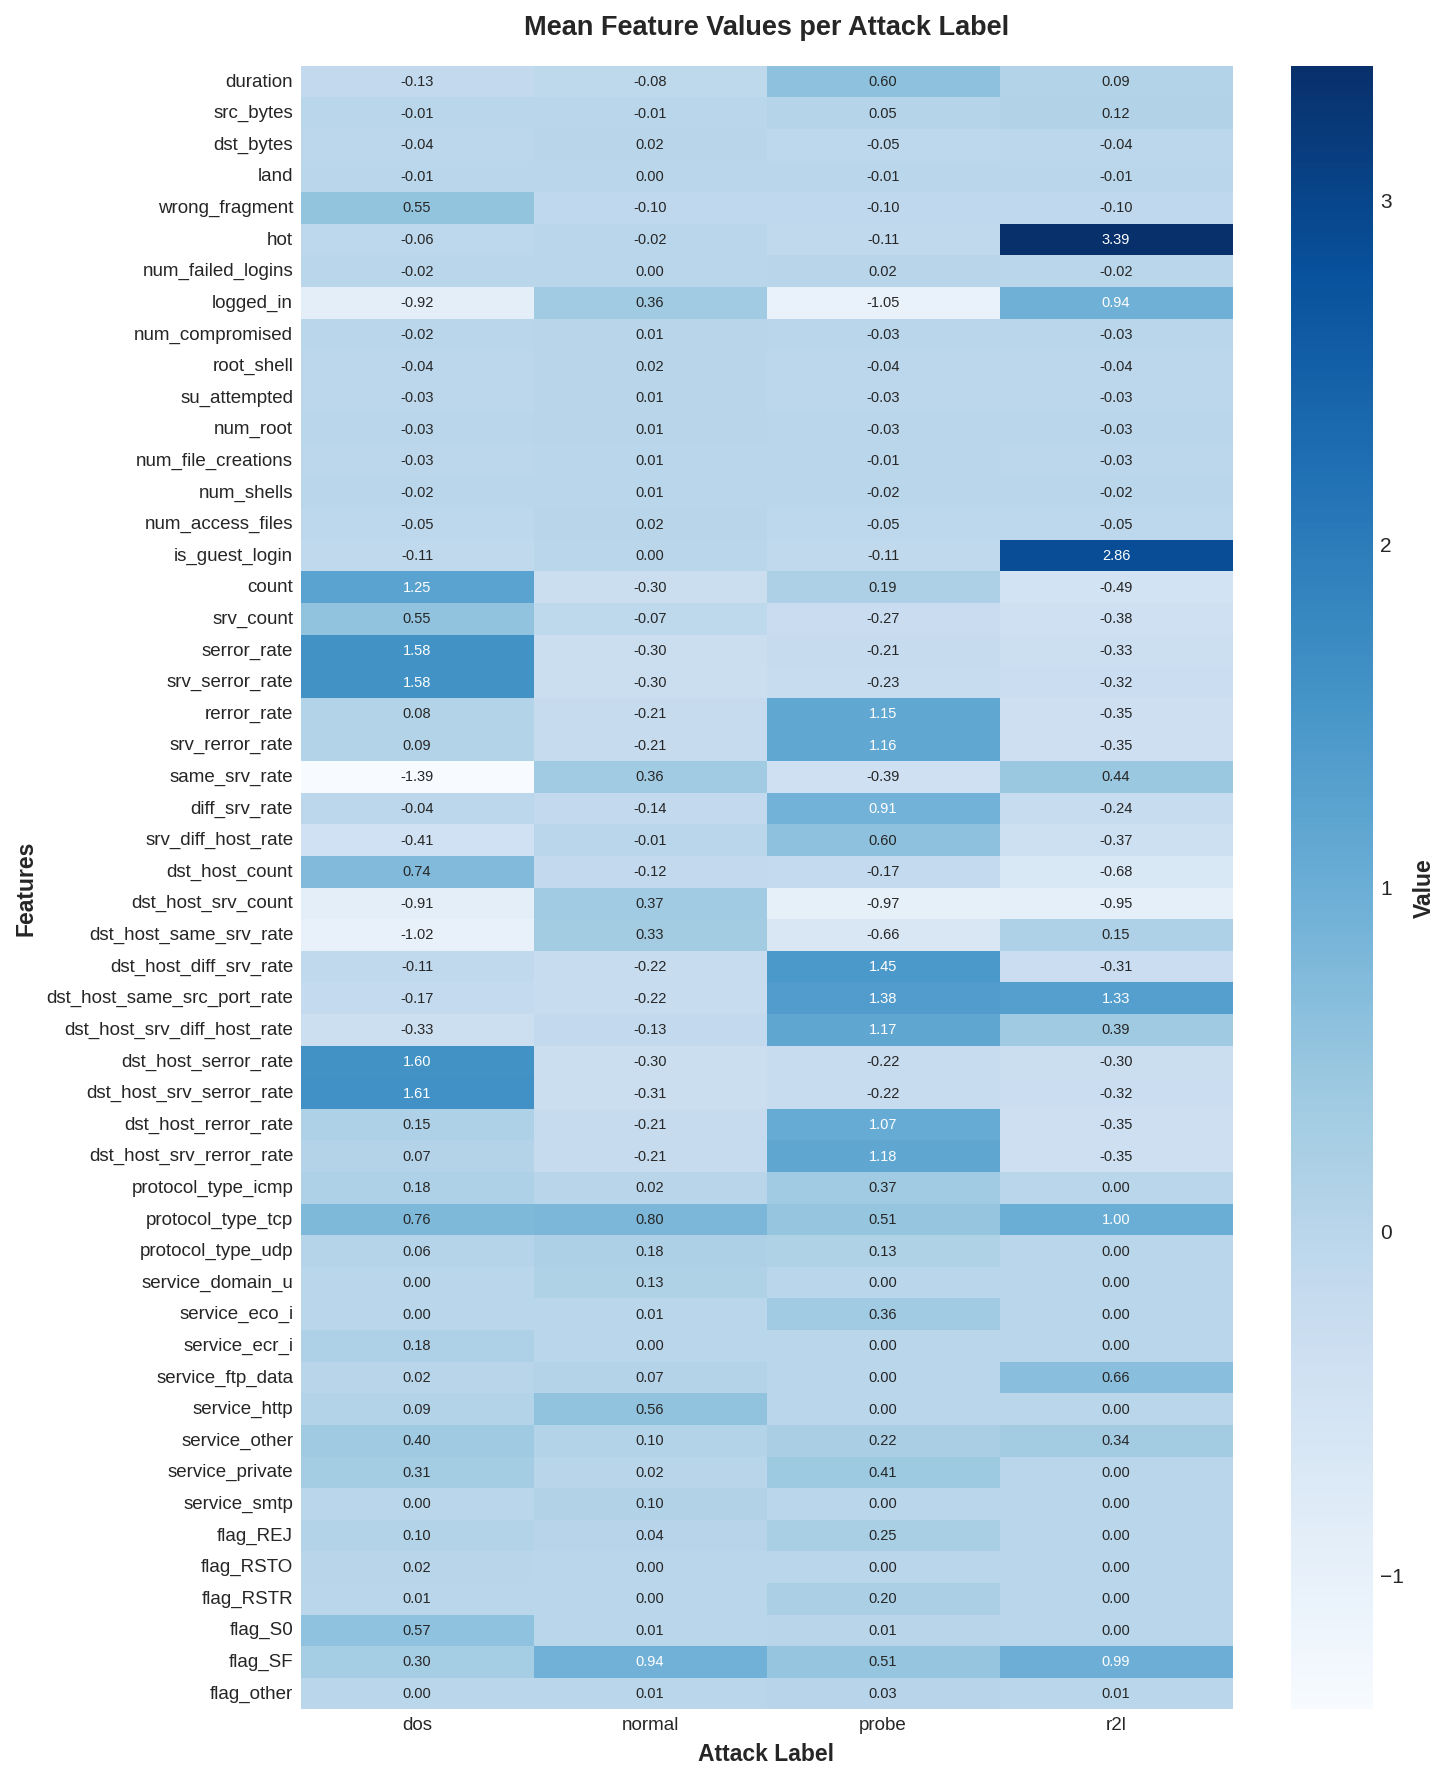

In [30]:
feature_cols = [col for col in df_train_preprocessed.columns if col not in ["label", "binary_label"]]
label_feature_means = df_train_preprocessed.groupby("label")[feature_cols].mean()

plot_heatmap(label_feature_means, "Mean Feature Values", "task1_heatmap_mean.png")

Figure saved to: ../Plots/Task1/task1_heatmap_std.png


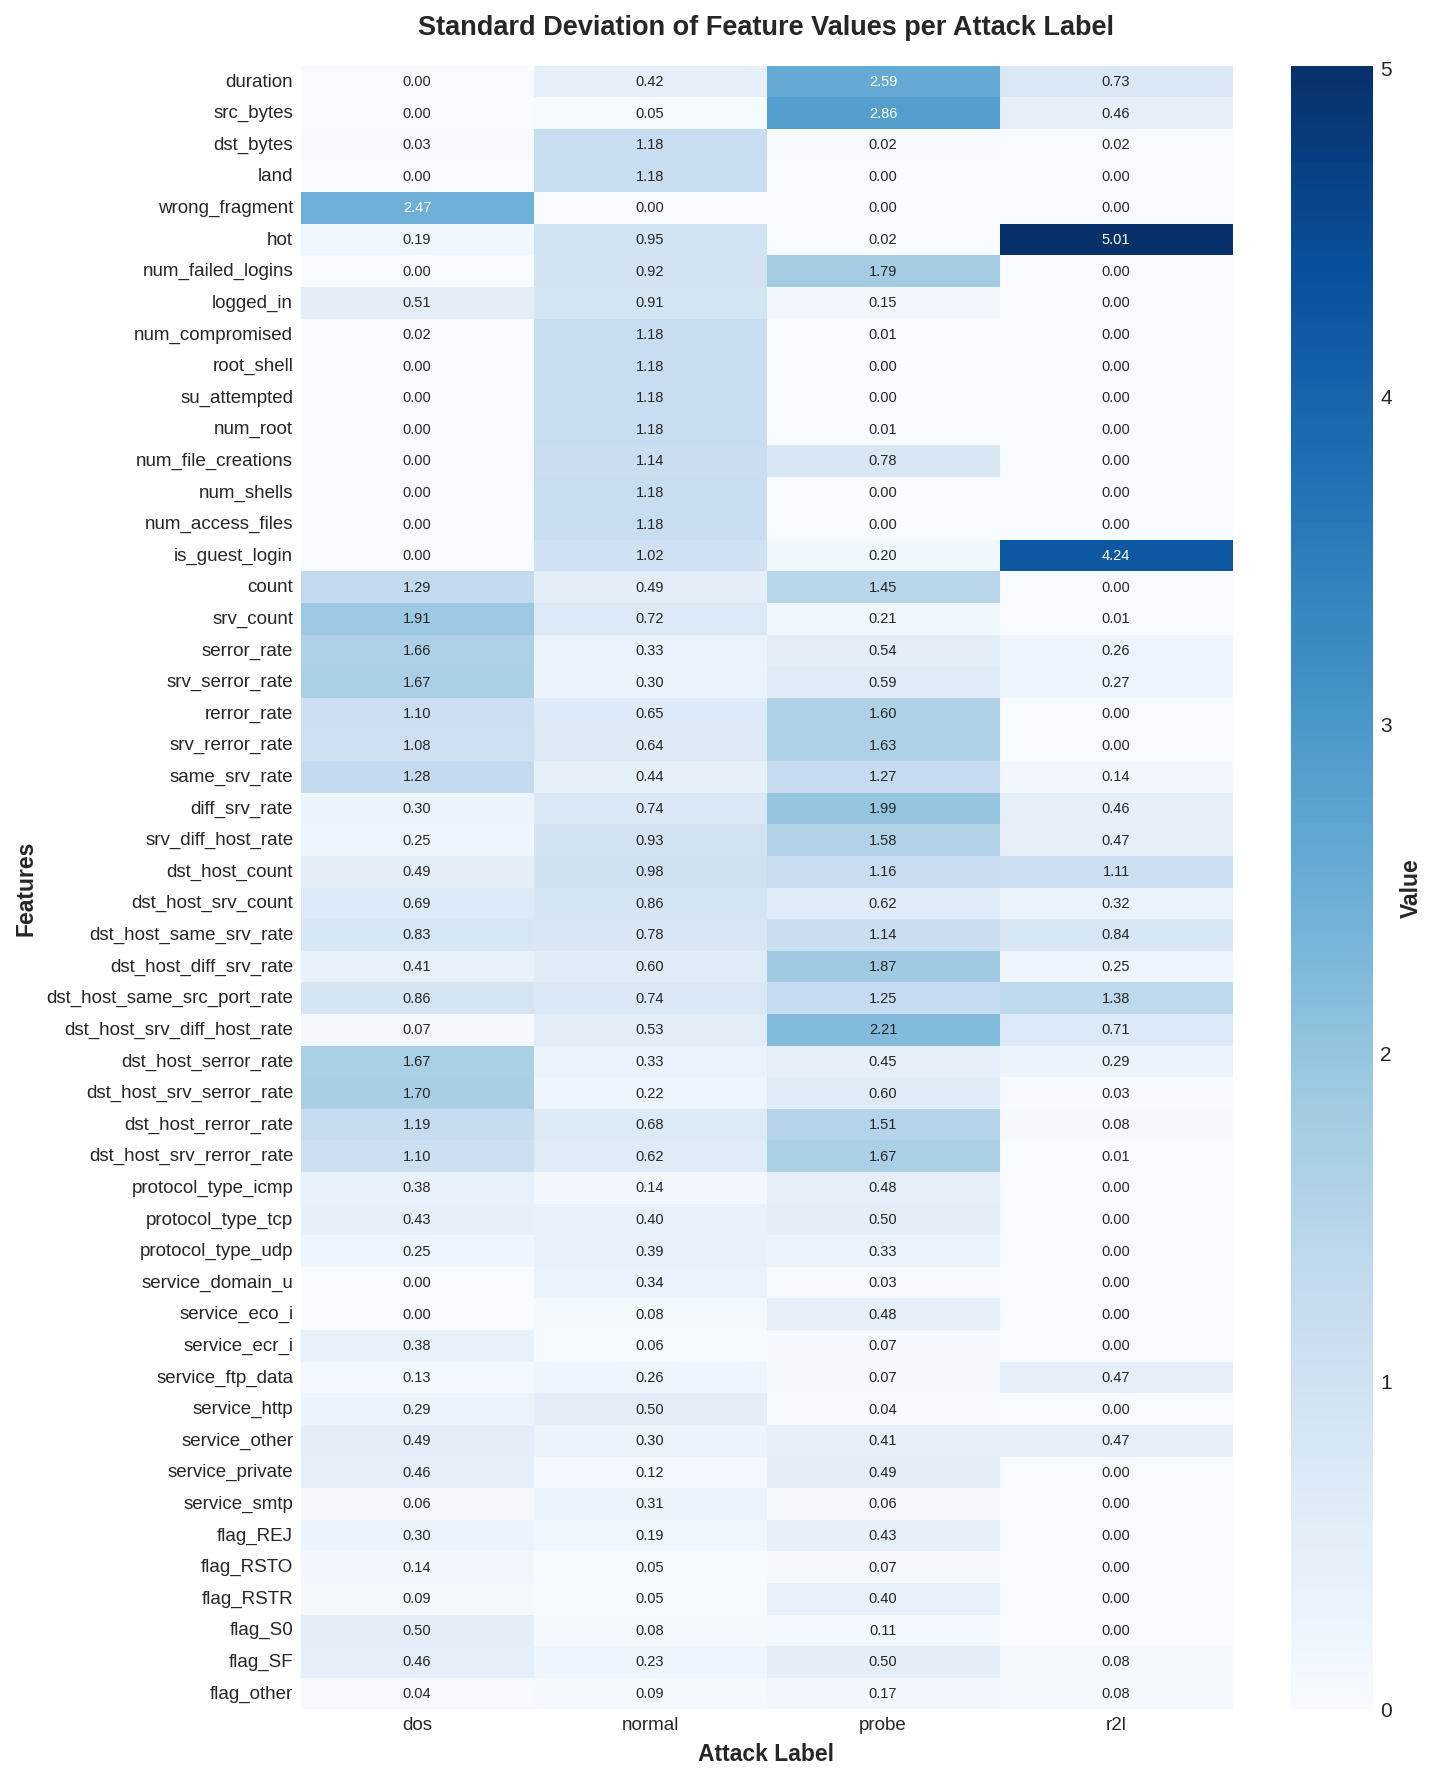

In [31]:
label_feature_std = df_train_preprocessed.groupby("label")[feature_cols].std()

plot_heatmap(label_feature_std, "Standard Deviation of Feature Values", "task1_heatmap_std.png")

Figure saved to: ../Plots/Task1/task1_heatmap_median.png


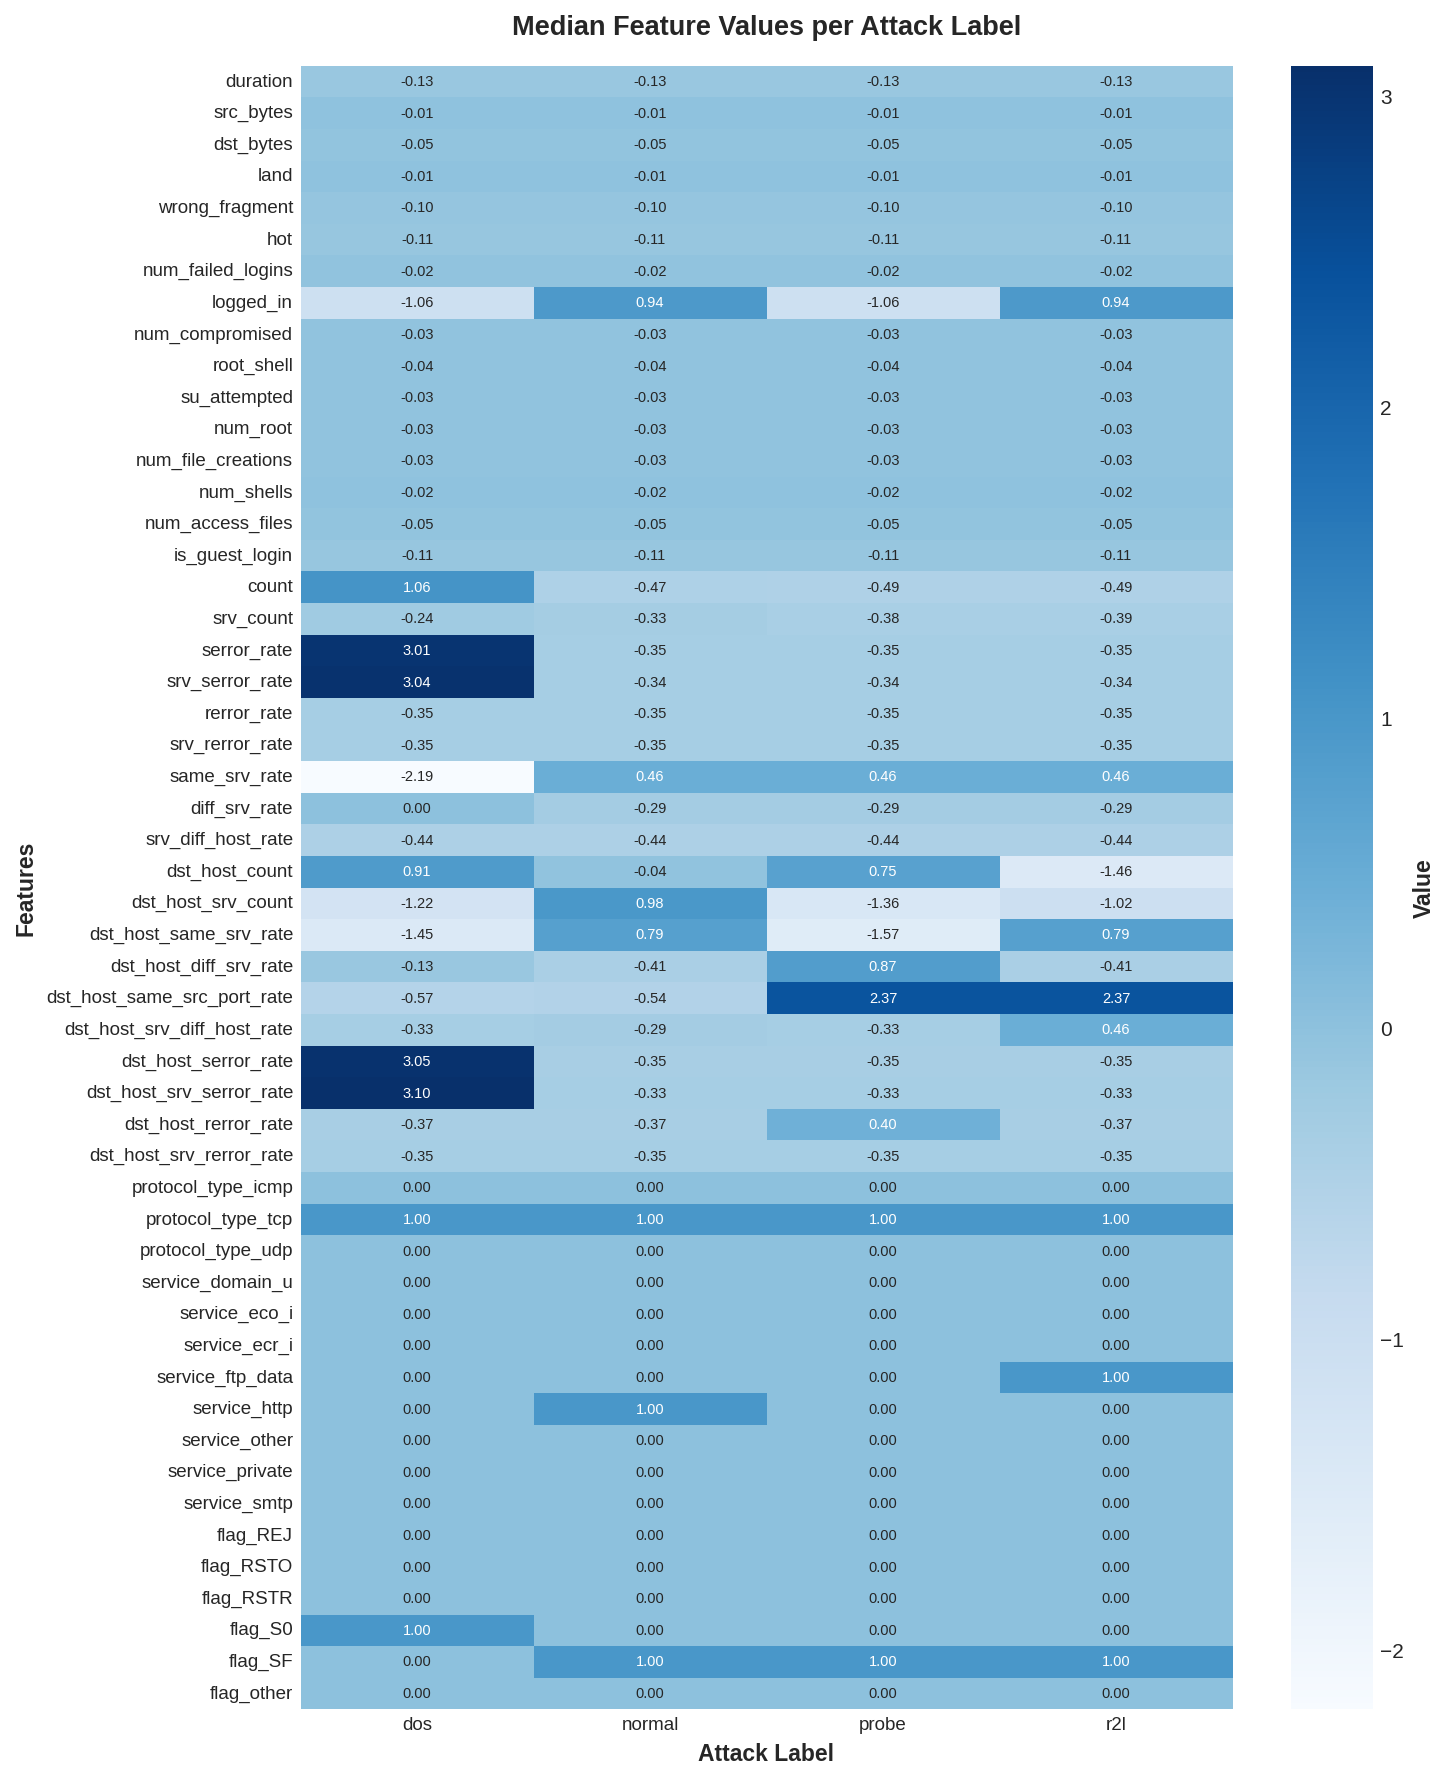

In [32]:
label_feature_median = df_train_preprocessed.groupby("label")[feature_cols].median()

plot_heatmap(label_feature_median, "Median Feature Values", "task1_heatmap_median.png")

### Question 3: Domain Expert Analysis
**Q: Looking at the different heatmaps, do you find any main characteristics that are strongly correlated with a specific attack?**

**Answer:**
The heatmaps (Mean, Standard Deviation, and Median) provide insights into feature behavior per class:
- **Mean Heatmap:** Shows the average value of features for each attack type. High mean values in specific features (like `count` or `srv_count` for DoS attacks) indicate a strong correlation.
- **Standard Deviation Heatmap:** Highlights the variability of features. High variability might indicate unstable behavior characteristic of certain attacks.
- **Median Heatmap:** Offers a robust view of central tendency, less affected by outliers than the mean.
- **Observation:** Specific features likely show distinct patterns for 'dos', 'probe', and 'r2l' compared to 'normal' traffic, which helps in distinguishing them. For instance, DoS attacks often exhibit high traffic rates (high counts), while Probe attacks might show different patterns in connection duration or error rates.

In [33]:
out_dir = Path("../data/preprocessed")
out_dir.mkdir(parents=True, exist_ok=True)


# Save preprocessed splits 
df_train_preprocessed.to_csv(out_dir / "train_preprocessed.csv", index=False)
df_val_preprocessed.to_csv(out_dir / "val_preprocessed.csv", index=False)
df_test_preprocessed.to_csv(out_dir / "test_preprocessed.csv", index=False)

print(f"Saved datasets to: {out_dir.resolve()}")

Saved datasets to: /home/ren/PERSONAL_DIRECTORY/CyberSecurity/Second_Year/First_Semester/AI4CYBERSEC/Laboratory3/lab/data/preprocessed
